In [6]:
from tqdm import tqdm
import optax
import haiku as hk
import jax
import numpy as np
from jax import jit, grad
import jax.numpy as jnp
from functools import partial
from IPython.display import display, HTML, clear_output
import time

from src.data import load_subject, make_kfolds
from src.model import loss_fn, init, apply
from src.plots import plot_brain
from src.utils import CONFIG, matrix_to_image
from src.train import train_folds, hyperparam_fn

In [2]:
subject = load_subject('subj05', image_size=CONFIG['image_size'])
hyperparams = hyperparam_fn()
kfolds = make_kfolds(subject, hyperparams)
metrics, params = train_folds(kfolds, hyperparams)

2023-09-16 09:15:32.502197: W pjrt_plugin/src/mps_client.cc:535] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!


Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



100%|██████████| 131/131 [00:07<00:00, 16.66it/s]



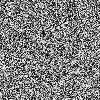
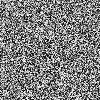
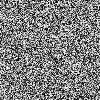
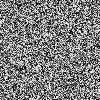

KeyboardInterrupt: 

In [38]:
def display_image(matrix_lst):
    html = '<div style="width: 300px; height: 300px; display: flex; flex-wrap: wrap;">'
    for matrix in matrix_lst:
        image = matrix_to_image(matrix)
        html += f"""
            <div style="display: flex; justify-content: center; align-items: center; width: 140px; height: 140px; margin: 5px; background-image: url('data:image/png;base64,{image}'); background-size: cover; background-position: center; background-repeat: no-repeat;">
            </div>"""

    html += '</div>'
    clear_output(wait=True)
    display(HTML(html))

# Example usage with a random 100x100 matrix
for i in range(10):
    matrix_lst = [np.random.rand(100, 100) for _ in range(4)]
    display_image(matrix_lst)
    time.sleep(1)